In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac')
sys.path.insert(1, '../../microcolony_analysis_giant_lorentz/')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale
import scienceplots
from seaborn import move_legend
from copy import deepcopy
from matplotlib.colors import LogNorm
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from matplotlib.colors import LogNorm, AsinhNorm, PowerNorm 
from tqdm.auto import tqdm
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.renderer import convolve_rescale, PSF_generator
import global_params_giant_colony as global_params
from glob import glob


In [2]:
def lorentzian_DoG(xdata_tuple, amplitude, xo, gamma, sigma1, sigma2, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma)**2 + ((y - xo) / gamma)**2)
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma2**2))
    return (lorentz * (gaussian_term_1 - gaussian_term_2)).ravel()

In [3]:
def calculate_new_offset(old_PSF_size, new_PSF_size, old_offset):
    area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)
    new_offset = old_offset / area_ratio
    return new_offset

In [4]:
large_colony= tifffile.imread("../../microcolony_analysis_giant_lorentz/data/fluorescent_scenes_3D/01664.tif")
large_colony = np.pad(large_colony, ((0,0),(200,200),(200,200)))
lorentz_psf_3D = tifffile.imread("../figure_1_separate/lorentz_psf_50nm_pix_size.tiff")


In [40]:
if not glob("colonies_convolved.p*"):
    colonies_convolved = []
    for PSF_size in np.arange(50,1200+600,250):
        lorentz_fit_params = np.load("../figure_1_separate/popts.npy")
        old_offsets = lorentz_fit_params[:,-1]
        lorentz_fit_params[:,-1] = calculate_new_offset(old_PSF_size=lorentz_psf_3D.shape[1], new_PSF_size=1500, old_offset=old_offsets)
        lorentz_fit_params[:,1] = PSF_size/2
        
        x = np.linspace(0, PSF_size-1, PSF_size)
        y = np.linspace(0, PSF_size-1, PSF_size)
        x, y = np.meshgrid(x, y)
            
        # Generate data from the optimal parameters
        large_PSF_3D_expanded = []
        for popt in lorentz_fit_params:
            lorentzian_PSF = lorentzian_DoG((x, y), *popt)
            large_PSF_3D_expanded.append(
                lorentzian_PSF.reshape(PSF_size, PSF_size)
            )
        large_PSF_3D_expanded = np.array(large_PSF_3D_expanded)
        
        lorentz_psf_3D_conv = large_PSF_3D_expanded[large_PSF_3D_expanded.shape[0]//2 - large_colony.shape[0]//2:large_PSF_3D_expanded.shape[0]//2+large_colony.shape[0]//2,:,:]
        lorentz_psf_3D_conv.shape
        
        post_conv_layer_scaling = lorentz_psf_3D_conv.sum(axis=(1,2))
        lorentz_psf_3D_conv_rescaled = []
        for i in lorentz_psf_3D_conv:
            #j = i - i.min()
            j = i / i.sum()
            lorentz_psf_3D_conv_rescaled.append(j)
        lorentz_psf_3D_conv_rescaled = np.array(lorentz_psf_3D_conv_rescaled)
        
        conv_colony_3D = np.array([convolve_rescale(colony_layer.astype(float), PSF_layer, 1, False) for colony_layer, PSF_layer in zip(tqdm(large_colony), lorentz_psf_3D_conv_rescaled)])
        plt.figure(figsize=(15,5))
        plt.imshow(conv_colony_3D.sum(axis=0), cmap="turbo", norm = LogNorm())
        plt.show()
        colonies_convolved.append(conv_colony_3D)

In [37]:
import pickle
pickle.dump( colonies_convolved, open( "colonies_convolved.p", "wb" ) )

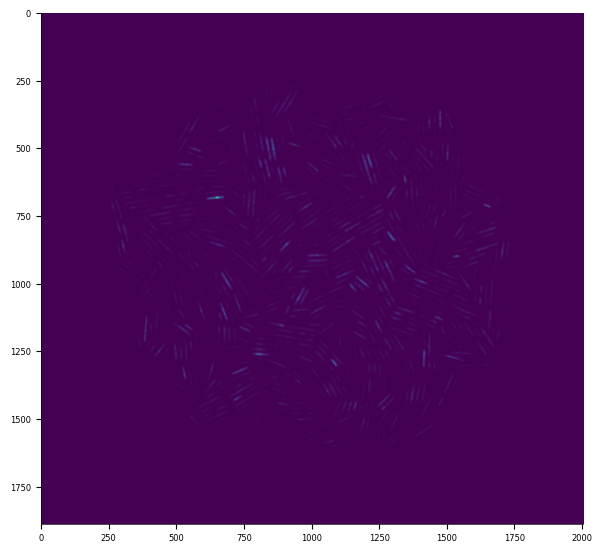

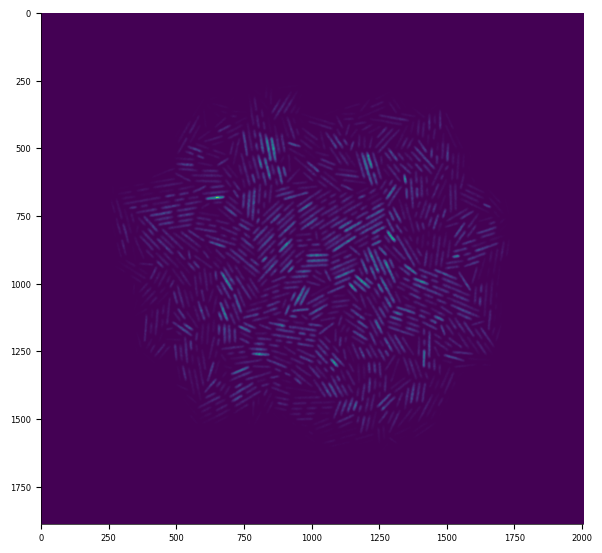

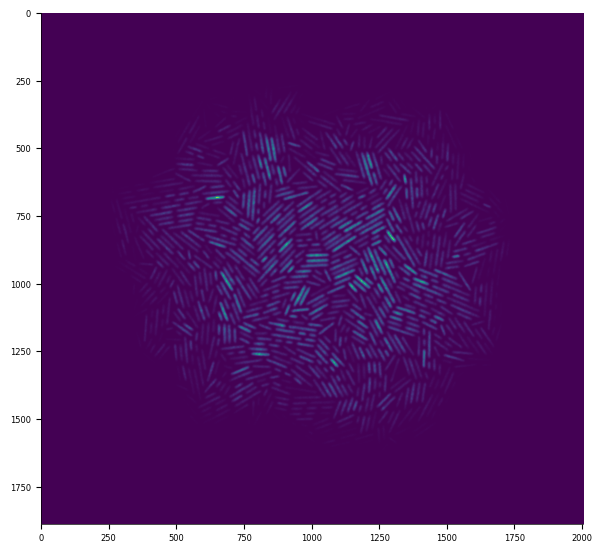

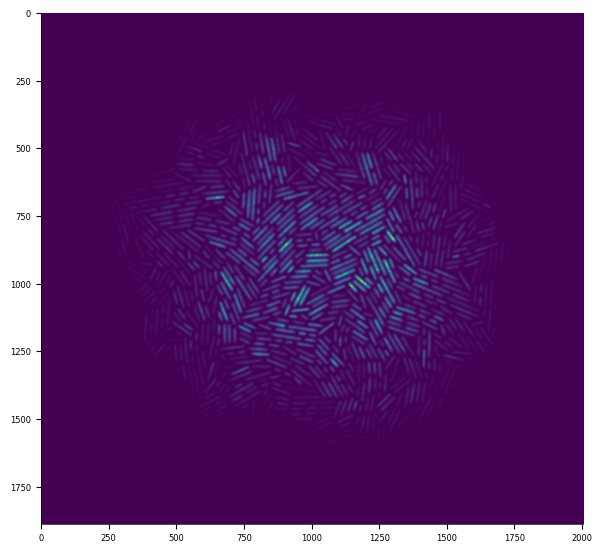

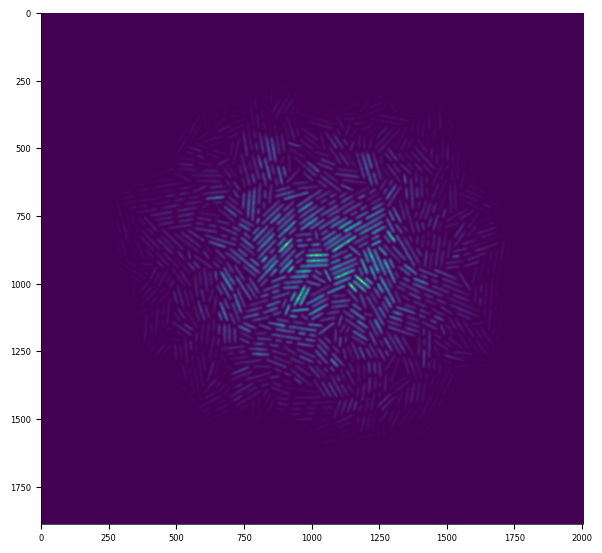

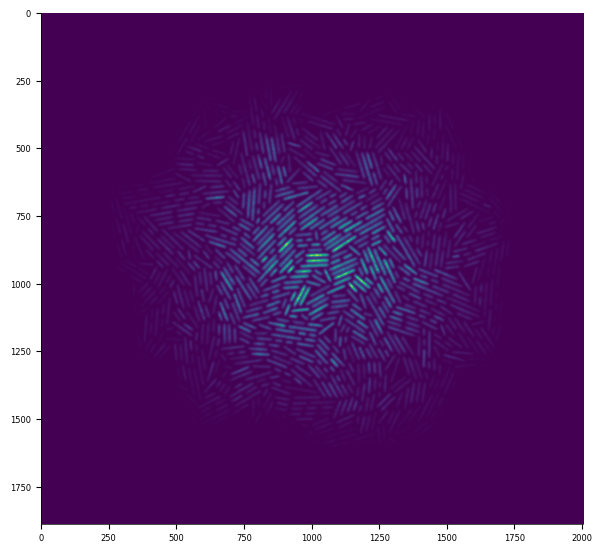

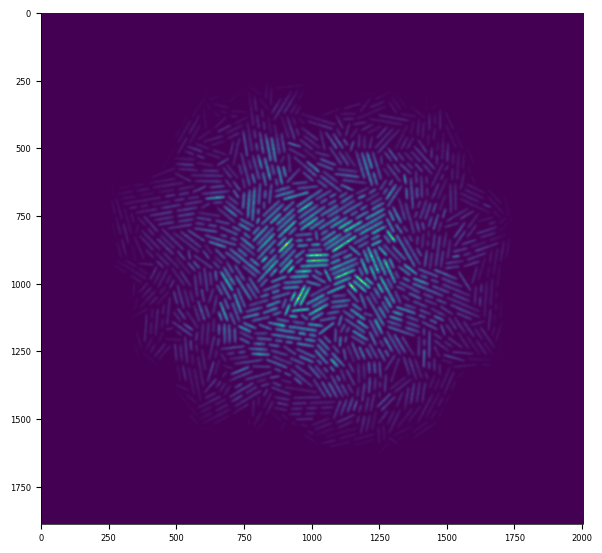

In [36]:
for colony in colonies_convolved:
    plt.figure(figsize=(7,7))
    plt.imshow(np.exp(colony.sum(axis=0)), )
    plt.show()

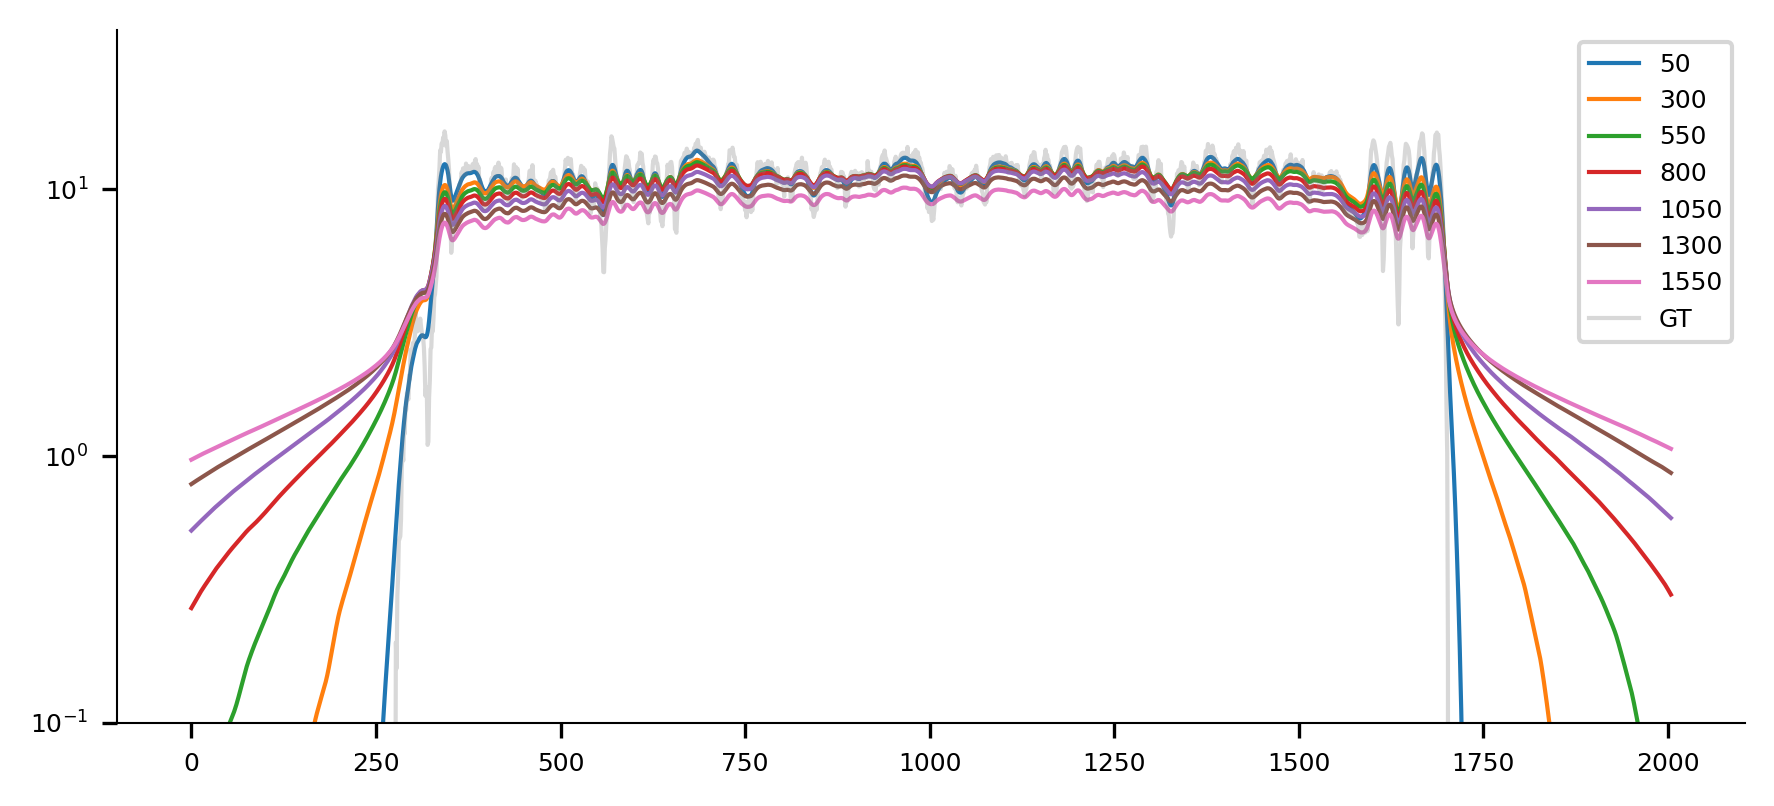

In [22]:
plt.figure(figsize=(7,3), dpi = 300)
for colony, PSF_size in zip(colonies_convolved, np.arange(50,1200+600,250)):
    plt.plot(colony.sum(axis=0)[950:1050,:].mean(axis=0), label = PSF_size)
    plt.legend()
plt.plot(large_colony.sum(axis=0)[950:1050,:].mean(axis=0), label = "GT", alpha = 0.3)
plt.yscale("log")
plt.ylim(0.1,)
plt.legend()
plt.show()


In [12]:
def calculate_radial_average(array, center=None):
    # Determine the center
    if center is None:
        center = (np.array(array.shape) / 2).astype(int)
    
    y, x = np.indices((array.shape))
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(int)

    # Bin the data on radius
    tbin = np.bincount(r.ravel(), array.ravel()) # Sum for each radius
    nr = np.bincount(r.ravel()) # Number of pixels in each radius bin
    radial_profile = tbin / nr

    return radial_profile

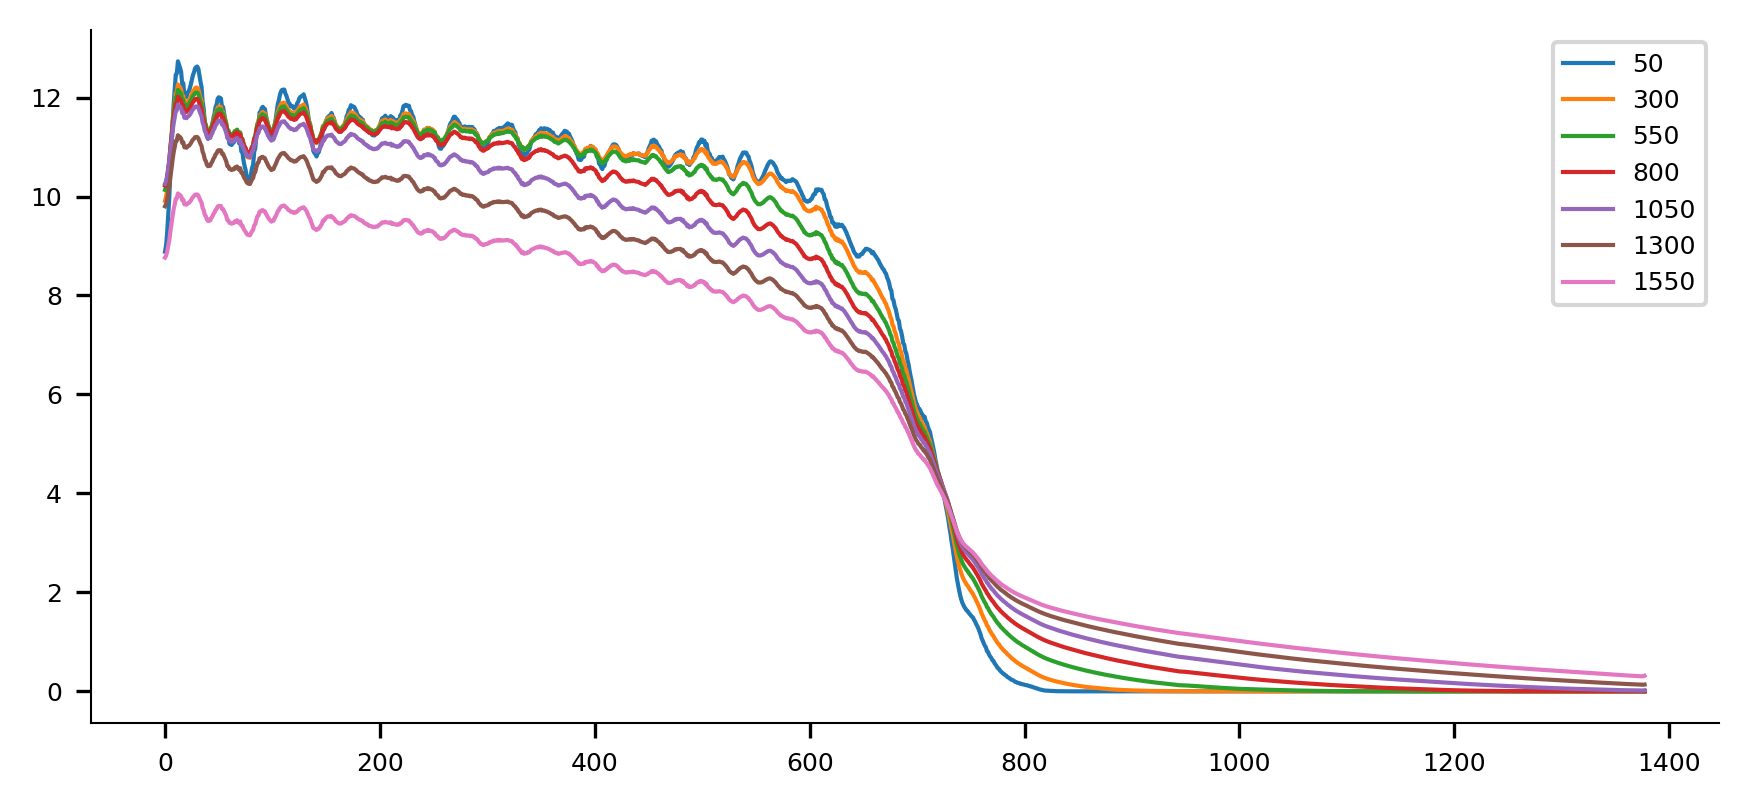

In [34]:
plt.figure(figsize=(7,3), dpi = 300)
for colony, PSF_size in zip(colonies_convolved, np.arange(50,1200+600,250)):
    plt.plot((
        calculate_radial_average(colony.sum(axis=0))
    ), label = PSF_size)
    plt.legend()
plt.show()
